# PM-JPL Sensitivity Analysis with ECOv002 Cal-Val

This notebook performs a sensitivity analysis of the PM-JPL model using ECOSTRESS Collection 2 Cal-Val data. It loads input data, processes it through the PM-JPL model, and visualizes the impact of input perturbations on latent heat flux. The notebook also generates figures for publication and explores the relationship between surface temperature and latent heat flux.

## Import Required Libraries and Functions

This cell imports all necessary libraries and functions for data processing, model execution, statistical analysis, and plotting. It includes custom modules for the PT-JPL-SM model, sensitivity analysis, and net radiation calculations, as well as standard scientific Python libraries.

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))

In [2]:
from typing import Callable
from os import makedirs
from os.path import join
import numpy as np
import pandas as pd
from verma_net_radiation import verma_net_radiation_table
from PMJPL import process_PMJPL_table, load_ECOv002_calval_PMJPL_inputs
from monte_carlo_sensitivity import perturbed_run, sensitivity_analysis, divide_absolute_by_unperturbed
import matplotlib.pyplot as plt
from scipy.stats import mstats
import seaborn as sns
from matplotlib.ticker import FuncFormatter

## Set Normalization Function

This cell assigns the normalization function used to compare perturbed model outputs to the unperturbed baseline. The function `divide_absolute_by_unperturbed` is used for normalization in the sensitivity analysis.

In [3]:
normalization_function = divide_absolute_by_unperturbed

## Load and Filter Input Data

This cell loads the ECOSTRESS Cal-Val input data using a custom loader function and filters out rows where `fAPARmax` is zero. The resulting DataFrame is displayed for inspection.

In [4]:
input_df = load_ECOv002_calval_PMJPL_inputs()
input_df

,Unnamed: 0,ID,vegetation,climate,STICinst,BESSinst,MOD16inst,PTJPLSMinst,ETinst,ETinstUncertainty,...,gl_sh,gl_e_wv,RBL_min,RBL_max,CL,Tmin_open,Tmin_closed,VPD_open,VPD_closed,Tmin_C
0,0,US-NC3,ENF,Cfa,270.345200,78.53355,392.851840,307.021970,487.383423,118.916280,...,0.02,0.02,20.0,50.0,0.0070,12.02,-8.0,650.0,4500.0,32.658920
1,1,US-Mi3,CVM,Dfb,232.141600,229.20093,640.118470,375.089300,106.825577,167.919460,...,0.08,0.08,25.0,45.0,0.0065,11.39,-8.0,650.0,3500.0,20.566360
2,2,US-Mi3,CVM,Dfb,356.355740,335.23154,625.661700,284.686250,NaN,132.936340,...,0.08,0.08,25.0,45.0,0.0065,11.39,-8.0,650.0,3500.0,20.566360
3,3,US-Mi3,CVM,Dfb,332.938400,326.68680,624.254330,251.414490,178.827545,141.132420,...,0.08,0.08,25.0,45.0,0.0065,11.39,-8.0,650.0,3500.0,20.566360
4,4,US-Mi3,CVM,Dfb,286.854030,237.21654,511.082180,228.520170,154.791626,114.809410,...,0.08,0.08,25.0,45.0,0.0065,11.39,-8.0,650.0,3500.0,20.566360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1042,1060,US-xAE,GRA,Cfa,70.923310,172.37459,81.645230,15.282976,NaN,56.385185,...,0.02,0.02,20.0,50.0,0.0070,12.02,-8.0,650.0,4200.0,3.815752
1043,1061,US-xAE,GRA,Cfa,116.543190,121.81641,65.469320,22.186659,NaN,40.509410,...,0.02,0.02,20.0,50.0,0.0070,12.02,-8.0,650.0,4200.0,3.815752
1044,1062,US-xAE,GRA,Cfa,129.880100,0.00000,118.777240,55.343586,NaN,52.403820,...,0.02,0.02,20.0,50.0,0.0070,12.02,-8.0,650.0,4200.0,3.815752
1045,1063,US-xAE,GRA,Cfa,2.707851,140.38632,126.490524,40.434025,NaN,57.769722,...,0.02,0.02,20.0,50.0,0.0070,12.02,-8.0,650.0,4200.0,3.815752


## Define Processing Function for Model Table

This cell defines a helper function that processes the input DataFrame through the Verma net radiation calculation and then the PT-JPL-SM model. This function is used in later analysis steps.

In [5]:
def process_verma_PMJPL_table(input_df: pd.DataFrame) -> pd.DataFrame:
    return process_PMJPL_table(verma_net_radiation_table(input_df))

## Process Input Data Through Model

This cell applies the processing function to the filtered input data, running it through the Verma net radiation and PT-JPL-SM model, and displays the resulting DataFrame.

In [6]:
processed = process_verma_PMJPL_table(input_df)
processed

[2025-09-10 14:29:24 INFO] starting Verma net radiation processing
[2025-09-10 14:29:24 INFO] variable SWout_Wm2 min: 0.000 mean: 66.238 max: 278.058 nan: 0.00% (nan)
[2025-09-10 14:29:24 INFO] variable SWnet_Wm2 min: 0.000 mean: 545.317 max: 929.140 nan: 0.00% (nan)
[2025-09-10 14:29:24 INFO] variable LWin_Wm2 min: 227.974 mean: 345.942 max: 473.521 nan: 0.00% (nan)
[2025-09-10 14:29:24 INFO] variable LWout_Wm2 min: 308.756 mean: 465.306 max: 693.334 nan: 0.00% (nan)
[2025-09-10 14:29:24 INFO] variable Rn_Wm2 min: 0.000 mean: 426.063 max: 843.390 nan: 0.00% (nan)
[2025-09-10 14:29:24 INFO] variable Rn_daylight_Wm2 min: 0.000 mean: 259.948 max: 443.569 nan: 0.00% (nan)
[2025-09-10 14:29:24 INFO] Verma net radiation processing complete in 0.02 seconds
[2025-09-10 14:29:24 INFO] starting PM-JPL table processing
[2025-09-10 14:29:24 INFO] started extracting geometry from PM-JPL input table
[2025-09-10 14:29:24 INFO] completed extracting geometry from PM-JPL input table
[2025-09-10 14:29:2

,Unnamed: 0,ID,vegetation,climate,STICinst,BESSinst,MOD16inst,PTJPLSMinst,ETinst,ETinstUncertainty,...,rtotc,rtot,rrs,ras,Asoil,wet_soil_evaporation_Wm2,potential_soil_evaporation_Wm2,fSM,LEs,LE_Wm2
0,0,US-NC3,ENF,Cfa,270.345200,78.53355,392.851840,307.021970,487.383423,118.916280,...,38.200872,35.510642,179.536728,29.646791,0.000000,0.000000,0.000000,1.891990e-03,0.000000,299.559254
1,1,US-Mi3,CVM,Dfb,232.141600,229.20093,640.118470,375.089300,106.825577,167.919460,...,38.090796,38.555330,207.744934,32.519959,0.000000,0.000000,0.000000,1.706940e-03,0.000000,263.840936
2,2,US-Mi3,CVM,Dfb,356.355740,335.23154,625.661700,284.686250,NaN,132.936340,...,40.562869,40.602210,202.648575,33.825091,0.000000,0.000000,0.000000,4.747452e-02,0.000000,252.630057
3,3,US-Mi3,CVM,Dfb,332.938400,326.68680,624.254330,251.414490,178.827545,141.132420,...,42.371784,43.310392,212.608566,35.980767,0.000000,0.000000,0.000000,8.928188e-02,0.000000,280.491994
4,4,US-Mi3,CVM,Dfb,286.854030,237.21654,511.082180,228.520170,154.791626,114.809410,...,40.988642,41.714993,210.457016,34.814383,0.000000,0.000000,0.000000,3.283667e-02,0.000000,263.373607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1042,1060,US-xAE,GRA,Cfa,70.923310,172.37459,81.645230,15.282976,NaN,56.385185,...,50.000000,58.951465,283.579712,48.805600,80.954786,0.009858,98.565845,6.076479e-02,5.999191,20.683094
1043,1061,US-xAE,GRA,Cfa,116.543190,121.81641,65.469320,22.186659,NaN,40.509410,...,44.135573,47.507790,229.279434,39.353547,86.726430,0.017991,179.889198,2.028228e-03,0.382847,16.416791
1044,1062,US-xAE,GRA,Cfa,129.880100,0.00000,118.777240,55.343586,NaN,52.403820,...,28.929644,28.989061,193.958206,25.219714,92.969470,0.029575,295.716840,4.581615e-08,0.029588,28.225251
1045,1063,US-xAE,GRA,Cfa,2.707851,140.38632,126.490524,40.434025,NaN,57.769722,...,48.531004,54.982557,258.345825,45.334272,101.426627,0.012458,124.563016,1.309988e-02,1.644219,26.537851


In [7]:
processed = processed.dropna(subset=['LEcorr50', 'LE_Wm2', 'ST_C'])
processed

,Unnamed: 0,ID,vegetation,climate,STICinst,BESSinst,MOD16inst,PTJPLSMinst,ETinst,ETinstUncertainty,...,rtotc,rtot,rrs,ras,Asoil,wet_soil_evaporation_Wm2,potential_soil_evaporation_Wm2,fSM,LEs,LE_Wm2
0,0,US-NC3,ENF,Cfa,270.345200,78.53355,392.851840,307.021970,487.383423,118.916280,...,38.200872,35.510642,179.536728,29.646791,0.000000,0.000000,0.000000,1.891990e-03,0.000000,299.559254
1,1,US-Mi3,CVM,Dfb,232.141600,229.20093,640.118470,375.089300,106.825577,167.919460,...,38.090796,38.555330,207.744934,32.519959,0.000000,0.000000,0.000000,1.706940e-03,0.000000,263.840936
2,2,US-Mi3,CVM,Dfb,356.355740,335.23154,625.661700,284.686250,NaN,132.936340,...,40.562869,40.602210,202.648575,33.825091,0.000000,0.000000,0.000000,4.747452e-02,0.000000,252.630057
3,3,US-Mi3,CVM,Dfb,332.938400,326.68680,624.254330,251.414490,178.827545,141.132420,...,42.371784,43.310392,212.608566,35.980767,0.000000,0.000000,0.000000,8.928188e-02,0.000000,280.491994
4,4,US-Mi3,CVM,Dfb,286.854030,237.21654,511.082180,228.520170,154.791626,114.809410,...,40.988642,41.714993,210.457016,34.814383,0.000000,0.000000,0.000000,3.283667e-02,0.000000,263.373607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1042,1060,US-xAE,GRA,Cfa,70.923310,172.37459,81.645230,15.282976,NaN,56.385185,...,50.000000,58.951465,283.579712,48.805600,80.954786,0.009858,98.565845,6.076479e-02,5.999191,20.683094
1043,1061,US-xAE,GRA,Cfa,116.543190,121.81641,65.469320,22.186659,NaN,40.509410,...,44.135573,47.507790,229.279434,39.353547,86.726430,0.017991,179.889198,2.028228e-03,0.382847,16.416791
1044,1062,US-xAE,GRA,Cfa,129.880100,0.00000,118.777240,55.343586,NaN,52.403820,...,28.929644,28.989061,193.958206,25.219714,92.969470,0.029575,295.716840,4.581615e-08,0.029588,28.225251
1045,1063,US-xAE,GRA,Cfa,2.707851,140.38632,126.490524,40.434025,NaN,57.769722,...,48.531004,54.982557,258.345825,45.334272,101.426627,0.012458,124.563016,1.309988e-02,1.644219,26.537851


## Accuracy Comparison of In-Situ Net Radiation to PM-JPL Latent Heat Flux

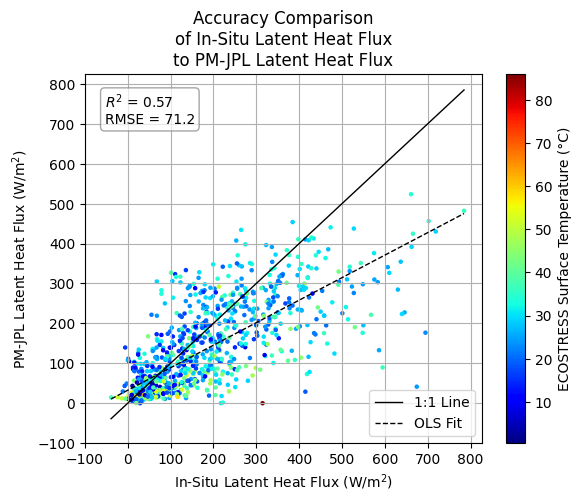

In [19]:
sc = plt.scatter(
    x=processed.LEcorr50,
    y=processed.LE_Wm2,
    c=processed.ST_C,
    cmap="jet",
    color=None,
    s=5
)

# Add 1-to-1 line
min_val = min(processed.LEcorr50.min(), processed.LE_Wm2.min())
max_val = max(processed.LEcorr50.max(), processed.LE_Wm2.max())
plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='-', linewidth=1, label='1:1 Line')

# Add OLS regression line
coefs = np.polyfit(processed.LEcorr50, processed.LE_Wm2, 1)
ols_x = np.array([min_val, max_val])
ols_y = coefs[0] * ols_x + coefs[1]
plt.plot(ols_x, ols_y, color='black', linestyle='--', linewidth=1, label='OLS Fit')

# Calculate R-squared and RMSE
from sklearn.metrics import r2_score, mean_squared_error
y_true = processed.LE_Wm2
y_pred = coefs[0] * processed.LEcorr50 + coefs[1]
r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Annotate R-squared and RMSE on plot
plt.annotate(f"$R^2$ = {r2:.2f}\nRMSE = {rmse:.1f}",
             xy=(0.05, 0.95), xycoords='axes fraction',
             ha='left', va='top',
             fontsize=10,
             bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.7))

# Set ticks every 100 for both axes
xticks = np.arange(100 * (min_val // 100), 100 * (max_val // 100 + 2), 100)
yticks = np.arange(100 * (min_val // 100), 100 * (max_val // 100 + 2), 100)
plt.xticks(xticks)
plt.yticks(yticks)

plt.grid(True, zorder=0) 
plt.xlabel("In-Situ Latent Heat Flux (W/m$^2$)")
plt.ylabel("PM-JPL Latent Heat Flux (W/m$^2$)")
plt.title("Accuracy Comparison\nof In-Situ Latent Heat Flux\nto PM-JPL Latent Heat Flux")
plt.colorbar(sc, label="ECOSTRESS Surface Temperature (°C)")
plt.legend()
plt.savefig("Accuracy Comparison of In-Situ Latent Heat Flux to PM-JPL Latent Heat Flux.jpeg", format='jpeg', bbox_inches='tight')
plt.savefig("Accuracy Comparison of In-Situ Latent Heat Flux to PM-JPL Latent Heat Flux.svg", format='svg', bbox_inches='tight')
plt.show()

## Plot Unperturbed Comparison of Surface Temperature to Latent Heat Flux

This cell creates a scatter plot comparing ECOSTRESS surface temperature to PM-JPL latent heat flux for the unperturbed data. The plot is saved as both JPEG and SVG files for publication or further analysis.

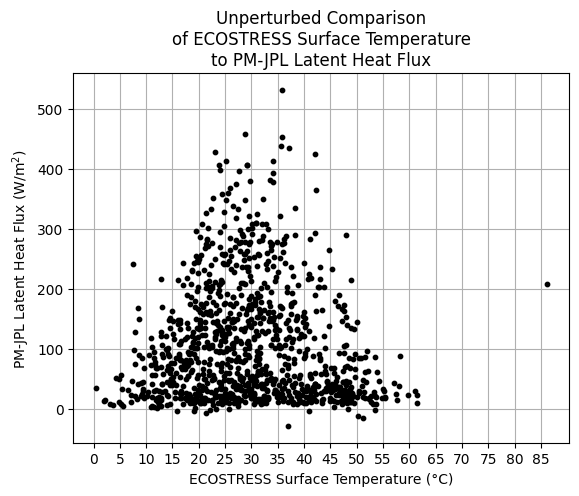

In [9]:
plt.xticks(range(int(min(processed.ST_C)), int(max(processed.ST_C)) + 1, 5))
plt.scatter(x=processed.ST_C, y=processed.LE, color='black', s=10, zorder=5)
plt.grid(True, zorder=0)
plt.xlabel("ECOSTRESS Surface Temperature (°C)")
plt.ylabel("PM-JPL Latent Heat Flux (W/m$^2$)")
plt.title("Unperturbed Comparison\nof ECOSTRESS Surface Temperature\nto PM-JPL Latent Heat Flux")

plt.savefig("Unperturbed Comparison of ECOSTRESS Surface Temperature to PM-JPL Latent Heat Flux.jpeg", format='jpeg', bbox_inches='tight')
plt.savefig("Unperturbed Comparison of ECOSTRESS Surface Temperature to PM-JPL Latent Heat Flux.svg", format='svg', bbox_inches='tight')

plt.show()

## Further Filter Input Data and Check Temperature Range

This cell applies additional filters to the input data, ensuring only valid `NDVI` values are included. It also checks the minimum and maximum surface temperature values in the filtered dataset.

In [10]:
# input_df = pd.read_csv(input_filename)
input_df = load_ECOv002_calval_PMJPL_inputs()

if "Ta" in input_df and "Ta_C" not in input_df:
    # input_df.rename({"Ta": "Ta_C"}, inplace=True)
    input_df["Ta_C"] = input_df["Ta"]

input_df = input_df[input_df.NDVI.apply(lambda NDVI: NDVI > 0.05)]

np.nanmin(input_df.ST_C), np.nanmax(input_df.ST_C)

(np.float64(0.4300000000000068), np.float64(86.11000000000001))

## Check Number of Valid Input Rows

This cell displays the number of rows remaining in the input DataFrame after all filtering steps, confirming the size of the dataset used for analysis.

In [11]:
len(input_df)

1047

## Run Perturbed Model Analysis

This cell sets up the input and output variables for the sensitivity analysis and runs the `perturbed_run` function, which perturbs the input variable and observes the effect on the output variable using the PM-JPL model. The results are displayed for further analysis.

In [12]:
input_variable = "ST_C"
output_variable = "LE_Wm2"

results = perturbed_run(
    input_df=input_df, 
    input_variable=input_variable, 
    output_variable=output_variable, 
    forward_process=process_verma_PMJPL_table,
    normalization_function=normalization_function
)

results

[2025-09-10 14:29:25 INFO] tarting Monte Carlo perturbed run
[2025-09-10 14:29:25 INFO] calculating standard deviation of input variable: ST_C
[2025-09-10 14:29:25 INFO] input variable ST_C standard deviation: 11.696580665393178
[2025-09-10 14:29:25 INFO] starting forward process
[2025-09-10 14:29:25 INFO] starting Verma net radiation processing
[2025-09-10 14:29:25 INFO] variable SWout_Wm2 min: 0.000 mean: 66.238 max: 278.058 nan: 0.00% (nan)
[2025-09-10 14:29:25 INFO] variable SWnet_Wm2 min: 0.000 mean: 545.317 max: 929.140 nan: 0.00% (nan)
[2025-09-10 14:29:25 INFO] variable LWin_Wm2 min: 227.974 mean: 345.942 max: 473.521 nan: 0.00% (nan)
[2025-09-10 14:29:25 INFO] variable LWout_Wm2 min: 308.756 mean: 465.306 max: 693.334 nan: 0.00% (nan)
[2025-09-10 14:29:25 INFO] variable Rn_Wm2 min: 0.000 mean: 426.063 max: 843.390 nan: 0.00% (nan)
[2025-09-10 14:29:25 INFO] variable Rn_daylight_Wm2 min: 0.000 mean: 259.948 max: 443.569 nan: 0.00% (nan)
[2025-09-10 14:29:25 INFO] Verma net radi

,input_variable,output_variable,input_unperturbed,input_perturbation,input_perturbation_std,input_perturbed,output_unperturbed,output_perturbation,output_perturbation_std,output_perturbed
0,ST_C,LE_Wm2,31.95,9.057132,0.283478,41.007132,299.559254,-27.551736,0.091974,272.007519
1,ST_C,LE_Wm2,31.95,-3.157164,0.098816,28.792836,299.559254,9.045223,0.030195,308.604477
2,ST_C,LE_Wm2,31.95,-2.435240,0.076220,29.51476,299.559254,7.001767,0.023374,306.561021
3,ST_C,LE_Wm2,31.95,-4.509530,0.141143,27.44047,299.559254,12.833936,0.042843,312.393191
4,ST_C,LE_Wm2,31.95,9.796880,0.306632,41.74688,299.559254,-29.910045,0.099847,269.649209
...,...,...,...,...,...,...,...,...,...,...
104695,ST_C,LE_Wm2,41.61,-20.113619,0.483384,21.496381,49.034706,7.024541,0.143257,56.059247
104696,ST_C,LE_Wm2,41.61,-12.960974,0.311487,28.649026,49.034706,4.684454,0.095533,53.719160
104697,ST_C,LE_Wm2,41.61,-11.677248,0.280636,29.932752,49.034706,4.246488,0.086602,53.281194
104698,ST_C,LE_Wm2,41.61,-8.446191,0.202985,33.163809,49.034706,3.11931,0.063614,52.154016


## Filter Out NaN Results

This cell removes any rows with missing values from the perturbed results to ensure only valid data points are used in subsequent analysis and plotting.

In [13]:
filtered_results = results.dropna()
filtered_results

,input_variable,output_variable,input_unperturbed,input_perturbation,input_perturbation_std,input_perturbed,output_unperturbed,output_perturbation,output_perturbation_std,output_perturbed
0,ST_C,LE_Wm2,31.95,9.057132,0.283478,41.007132,299.559254,-27.551736,0.091974,272.007519
1,ST_C,LE_Wm2,31.95,-3.157164,0.098816,28.792836,299.559254,9.045223,0.030195,308.604477
2,ST_C,LE_Wm2,31.95,-2.435240,0.076220,29.51476,299.559254,7.001767,0.023374,306.561021
3,ST_C,LE_Wm2,31.95,-4.509530,0.141143,27.44047,299.559254,12.833936,0.042843,312.393191
4,ST_C,LE_Wm2,31.95,9.796880,0.306632,41.74688,299.559254,-29.910045,0.099847,269.649209
...,...,...,...,...,...,...,...,...,...,...
104695,ST_C,LE_Wm2,41.61,-20.113619,0.483384,21.496381,49.034706,7.024541,0.143257,56.059247
104696,ST_C,LE_Wm2,41.61,-12.960974,0.311487,28.649026,49.034706,4.684454,0.095533,53.719160
104697,ST_C,LE_Wm2,41.61,-11.677248,0.280636,29.932752,49.034706,4.246488,0.086602,53.281194
104698,ST_C,LE_Wm2,41.61,-8.446191,0.202985,33.163809,49.034706,3.11931,0.063614,52.154016


## Plot Change in Surface Temperature vs Latent Heat Flux

This cell generates a scatter plot showing the relationship between changes in surface temperature and changes in PM-JPL latent heat flux due to input perturbations. The plot is saved as JPEG and SVG files.

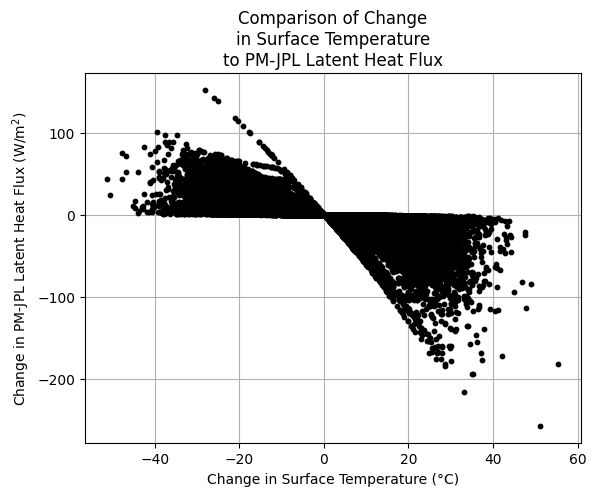

In [14]:
# plt.xticks(range(int(min(processed.ST_C)), int(max(processed.ST_C)) + 1, 5))
# plt.ylim(-350, 150)
plt.scatter(x=results.input_perturbation, y=results.output_perturbation, color='black', s=10, zorder=5)  # Adjust the 's' parameter to make dots thinner
plt.grid(True, zorder=0)
plt.xlabel("Change in Surface Temperature (°C)")
plt.ylabel("Change in PM-JPL Latent Heat Flux (W/m$^2$)")
plt.title("Comparison of Change\nin Surface Temperature\nto PM-JPL Latent Heat Flux")

plt.savefig("Comparison of Change in Surface Temperature to PM-JPL Latent Heat Flux.jpeg", format='jpeg', bbox_inches='tight')
plt.savefig("Comparison of Change in Surface Temperature to PM-JPL Latent Heat Flux.svg", format='svg', bbox_inches='tight')

plt.show()

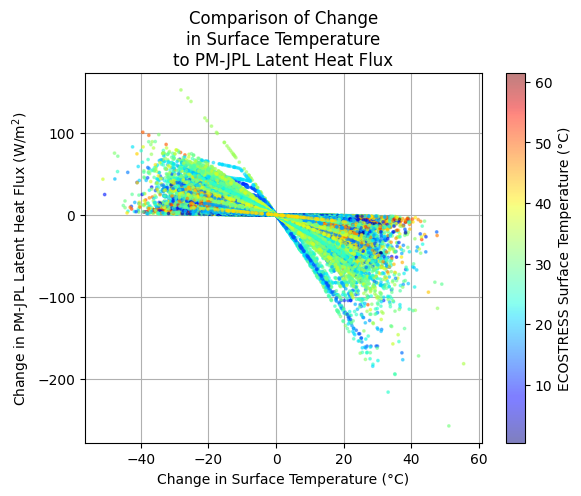

In [15]:
sc = plt.scatter(
    x=results.input_perturbation, 
    y=results.output_perturbation, 
    c=results.input_unperturbed, 
    color=None,
    cmap="jet",
    s=3,
    alpha=0.5, 
    zorder=5
)

plt.grid(True, zorder=0)
plt.xlabel("Change in Surface Temperature (°C)")
plt.ylabel("Change in PM-JPL Latent Heat Flux (W/m$^2$)")
plt.title("Comparison of Change\nin Surface Temperature\nto PM-JPL Latent Heat Flux")
plt.colorbar(sc, label="ECOSTRESS Surface Temperature (°C)")
plt.savefig("Comparison of Change in Surface Temperature to PM-JPL Latent Heat Flux.jpeg", format='jpeg', bbox_inches='tight')
plt.savefig("Comparison of Change in Surface Temperature to PM-JPL Latent Heat Flux.svg", format='svg', bbox_inches='tight')

plt.show()

## Compute Correlation Between Input and Output Perturbations

This cell calculates the Pearson correlation coefficient between the standardized input and output perturbations, quantifying the strength of their linear relationship.

In [16]:
correlation = mstats.pearsonr(
    np.array(filtered_results.input_perturbation_std).astype(np.float64), 
    np.array(filtered_results.output_perturbation_std).astype(np.float64)
)[0]

correlation

np.float64(0.03035187182891283)

## Run Full Sensitivity Analysis for Multiple Inputs

This cell performs a comprehensive sensitivity analysis by perturbing several input variables (surface temperature, NDVI, albedo, air temperature, relative humidity) and measuring their effect on latent heat flux. The results are summarized in a DataFrame.

In [17]:
input_variables = ["ST_C", "NDVI", "albedo", "Ta_C", "RH"]
output_variables = ["LE_Wm2"]

perturbation_df, sensitivity_metrics_df = sensitivity_analysis(
    input_df=input_df,
    input_variables=input_variables,
    output_variables=output_variables,
    forward_process=process_verma_PMJPL_table,
    normalization_function=normalization_function
)

sensitivity_metrics_df

[2025-09-10 14:29:36 INFO] tarting Monte Carlo perturbed run
[2025-09-10 14:29:36 INFO] calculating standard deviation of input variable: ST_C
[2025-09-10 14:29:36 INFO] input variable ST_C standard deviation: 11.696580665393178
[2025-09-10 14:29:36 INFO] starting forward process
[2025-09-10 14:29:36 INFO] starting Verma net radiation processing
[2025-09-10 14:29:36 INFO] variable SWout_Wm2 min: 0.000 mean: 66.238 max: 278.058 nan: 0.00% (nan)
[2025-09-10 14:29:36 INFO] variable SWnet_Wm2 min: 0.000 mean: 545.317 max: 929.140 nan: 0.00% (nan)
[2025-09-10 14:29:36 INFO] variable LWin_Wm2 min: 227.974 mean: 345.942 max: 473.521 nan: 0.00% (nan)
[2025-09-10 14:29:36 INFO] variable LWout_Wm2 min: 308.756 mean: 465.306 max: 693.334 nan: 0.00% (nan)
[2025-09-10 14:29:36 INFO] variable Rn_Wm2 min: 0.000 mean: 426.063 max: 843.390 nan: 0.00% (nan)
[2025-09-10 14:29:36 INFO] variable Rn_daylight_Wm2 min: 0.000 mean: 259.948 max: 443.569 nan: 0.00% (nan)
[2025-09-10 14:29:36 INFO] Verma net radi

/opt/homebrew/Caskroom/miniforge/base/envs/PM-JPL/lib/python3.10/site-packages/monte_carlo_sensitivity/sensitivity_analysis.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  perturbation_df = pd.concat([perturbation_df, run_results])
/opt/homebrew/Caskroom/miniforge/base/envs/PM-JPL/lib/python3.10/site-packages/monte_carlo_sensitivity/sensitivity_analysis.py:89: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sensitivity_metrics_df = pd.concat([sensitivity_metrics_df, pd.DataFrame([[


[2025-09-10 14:29:42 INFO] starting Verma net radiation processing
[2025-09-10 14:29:42 INFO] variable SWout_Wm2 min: 0.000 mean: 66.238 max: 278.058 nan: 0.00% (nan)
[2025-09-10 14:29:42 INFO] variable SWnet_Wm2 min: 0.000 mean: 545.317 max: 929.140 nan: 0.00% (nan)
[2025-09-10 14:29:42 INFO] variable LWin_Wm2 min: 227.974 mean: 345.942 max: 473.521 nan: 0.00% (nan)
[2025-09-10 14:29:42 INFO] variable LWout_Wm2 min: 308.756 mean: 465.306 max: 693.334 nan: 0.00% (nan)
[2025-09-10 14:29:42 INFO] variable Rn_Wm2 min: 0.000 mean: 426.063 max: 843.390 nan: 0.00% (nan)
[2025-09-10 14:29:43 INFO] variable Rn_daylight_Wm2 min: 0.000 mean: 259.948 max: 443.569 nan: 0.00% (nan)
[2025-09-10 14:29:43 INFO] Verma net radiation processing complete in 1.26 seconds
[2025-09-10 14:29:43 INFO] starting PM-JPL table processing
[2025-09-10 14:29:43 INFO] started extracting geometry from PM-JPL input table
[2025-09-10 14:29:44 INFO] completed extracting geometry from PM-JPL input table
[2025-09-10 14:29:4

/opt/homebrew/Caskroom/miniforge/base/envs/PM-JPL/lib/python3.10/site-packages/carlson_leaf_area_index/carlson_leaf_area_index.py:66: RuntimeWarning: divide by zero encountered in log
  LAI = rt.clip(-np.log(1 - fIPAR) * (1 / KPAR), min_LAI, max_LAI)  # Beer-Lambert law for canopy


[2025-09-10 14:29:44 INFO] PM-JPL table processing complete
[2025-09-10 14:29:44 INFO] completed forward process for perturbed input
[2025-09-10 14:29:44 INFO] normalizing output perturbations
[2025-09-10 14:29:44 INFO] Monte Carlo run complete
[2025-09-10 14:29:45 INFO] tarting Monte Carlo perturbed run
[2025-09-10 14:29:45 INFO] calculating standard deviation of input variable: albedo
[2025-09-10 14:29:45 INFO] input variable albedo standard deviation: 0.05290663726097777
[2025-09-10 14:29:45 INFO] starting forward process
[2025-09-10 14:29:45 INFO] starting Verma net radiation processing
[2025-09-10 14:29:45 INFO] variable SWout_Wm2 min: 0.000 mean: 66.238 max: 278.058 nan: 0.00% (nan)
[2025-09-10 14:29:45 INFO] variable SWnet_Wm2 min: 0.000 mean: 545.317 max: 929.140 nan: 0.00% (nan)
[2025-09-10 14:29:45 INFO] variable LWin_Wm2 min: 227.974 mean: 345.942 max: 473.521 nan: 0.00% (nan)
[2025-09-10 14:29:45 INFO] variable LWout_Wm2 min: 308.756 mean: 465.306 max: 693.334 nan: 0.00% (n

/Users/halverso/Projects/PM-JPL/PMJPL/soil_moisture_constraint.py:19: RuntimeWarning: invalid value encountered in power
  return RH ** (VPD / beta)


[2025-09-10 14:29:57 INFO] normalizing output perturbations
[2025-09-10 14:29:57 INFO] Monte Carlo run complete


,input_variable,output_variable,metric,value
0,ST_C,LE_Wm2,correlation,0.029986
0,ST_C,LE_Wm2,r2,0.000899
0,ST_C,LE_Wm2,mean_normalized_change,0.094927
0,NDVI,LE_Wm2,correlation,0.888376
0,NDVI,LE_Wm2,r2,0.789211
0,NDVI,LE_Wm2,mean_normalized_change,1.313585
0,albedo,LE_Wm2,correlation,0.173137
0,albedo,LE_Wm2,r2,0.029977
0,albedo,LE_Wm2,mean_normalized_change,0.031773
0,Ta_C,LE_Wm2,correlation,0.040849


## Plot Sensitivity Magnitude Bar Chart

This cell creates a bar chart showing the average percent change in latent heat flux for each input variable, visualizing the magnitude of model sensitivity to each input. The plot is saved as JPEG and SVG files with the PT-JPL-SM label.

/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_96675/2617240293.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Surface\nTemperature", "NDVI", "Albedo", "Air\nTemperature", "Relative\nHumidity"])


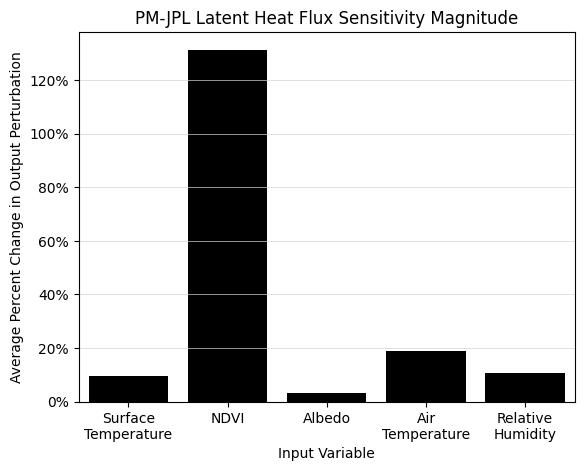

In [18]:
df = sensitivity_metrics_df
df = df[(df.output_variable == "LE_Wm2") & (df.metric == "mean_normalized_change")]
ax = sns.barplot(x=df.input_variable, y=df.value * 100, color='black')
ax.set_xticklabels(["Surface\nTemperature", "NDVI", "Albedo", "Air\nTemperature", "Relative\nHumidity"])
plt.xlabel("Input Variable")
plt.ylabel("Average Percent Change in Output Perturbation")
plt.title("PM-JPL Latent Heat Flux Sensitivity Magnitude")
# plt.ylim(0, 160)  # Set y-axis range from 0 to 160
plt.grid(axis='y', color='lightgray', linestyle='-', linewidth=0.5)  # Add light gray horizontal gridlines only

# Add percent sign to y-axis tick labels
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y)}%'))

plt.savefig("PM-JPL Latent Heat Flux Sensitivity Magnitude.jpeg", format='jpeg', bbox_inches='tight')
plt.savefig("PM-JPL Latent Heat Flux Sensitivity Magnitude.svg", format='svg', bbox_inches='tight')

plt.show()

## Summary and Next Steps

This notebook demonstrated a full sensitivity analysis workflow for the PT-JPL-SM model using ECOSTRESS Cal-Val data. Key results include the identification of input variables with the greatest influence on latent heat flux. Next steps could include further exploration of model parameters, additional visualizations, or application to other datasets.